In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.plotly as py
import plotly.graph_objs as go 
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#plotly.tools.set_credentials_file(username='slotbite', api_key='GYgRt3eXz6IdiIy3k7sO')
py.plotly.tools.set_credentials_file(username='cachulooo', api_key='srvpWbqoQ27WdGO3pArx')

 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 20)

In [33]:
# Cargando datos
data = pd.read_csv("segmentacion_clientes.csv" , delimiter=";" , decimal="," , encoding='utf-8')
df=data

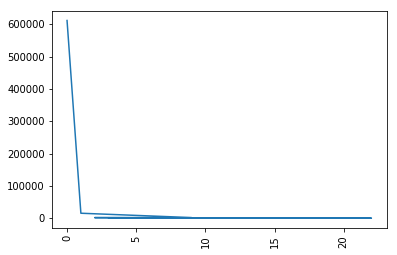

In [71]:
sample=df
#sample = df[(sample.QUEJAS==2) ] 
plt.xticks(rotation=90)
plt.plot(sample.groupby('QUEJAS').size().sort_values(ascending=False))
 

## Categorización y encodificación de variables 

In [3]:
## Se eliminan preduct_id mal formados (-)
#df[df.PRODUCT_ID < 0] 
df = df[df.PRODUCT_ID > 0] 


## Convertimos las variables categoricas
#http://pbpython.com/categorical-encoding.html
pd.options.mode.chained_assignment = None
df["COMUNA"] = df["COMUNA"].astype('category')
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].astype('category')
df["TI"] = df["TI"].astype('category')
df["TI2"] = df["TI2"].astype('category')

# luego la encodificamos 
df["TI"] = df["TI"].cat.codes
df["TI2"] = df["TI2"].cat.codes
df["COMUNA_ENC"] = df["COMUNA"].cat.codes 
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].cat.codes 
df[:3]

,PRODUCT_ID,SUBSCRIPTION_ID,SUBSCRIBER_ID,COMUNA,TI,TI2,TIPO_REPARTO,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC
0,122551,122551,13185036,128 - San Esteban ...,0,0,0,0,0,0,0,18964.8333,33256.6667,1.753504,9
1,122581,122581,122581,128 - San Esteban ...,0,0,0,0,0,0,0,28445.7500,36605.0833,1.286793,9
2,109938,109938,3665521,145 - San Felipe ...,0,1,0,0,0,1,0,135045.4170,327823.5000,2.427488,22


## Selección de variables

In [29]:
sample=df[['QUEJAS', 'DAÑOS',
            'CORTES', 'RECLAMOS','FACTURACION_PROMEDIO',
            'SALDO_PROMEDIO', 'ROTACION_CARTERA' ,
           'COMUNA_ENC' , 'TI' , 'TI2' ,'TIPO_REPARTO' ]].sample(frac=1, random_state=42)
sample.shape

(631293, 11)

# Solo número de quejas 2 (todo el dataset)

In [30]:
sample = sample[(sample.QUEJAS==14) | (sample.QUEJAS==9)]
sample.shape[0]

2316

,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC,TI,TI2,TIPO_REPARTO
16002,9,1,0,0,136599.54500,136599.545,0.999993,0,1,1,1
42463,14,0,0,0,368354.45500,805995.300,2.188091,5,0,1,1
42504,14,0,1,0,5804.36364,9202.200,1.585120,5,0,1,1
608529,14,0,0,0,89906.90910,384406.182,4.275555,5,0,1,1
17170,9,0,0,0,158716.09100,158716.091,0.999994,0,1,1,1


## Silhouette  test
Determina el numero optimo de clusters



In [24]:
import hdbscan 

rango_vecinos=[]
num_clusters = []
silueta = []

X = np.array(sample )  
# Estandarización
#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

for n in   range(1 , 1000) :  
    model = hdbscan.HDBSCAN(min_cluster_size=n+1 ,metric='manhattan').fit(X) 
    n_clusters_ = len(set(model.labels_ )) - (1 if -1 in model.labels_  else 0)
    
    if n_clusters_!= 0 :
        rango_vecinos.append(n+1)
        num_clusters.append( n_clusters_ )
        silueta.append( metrics.silhouette_score( X , model.labels_ ))  
    else:
        break;
    
bench_df = pd.DataFrame( {"num_vecinos":rango_vecinos, "num_clusters": num_clusters  , "silueta":silueta} ) 

In [31]:
bench_df.to_csv('bench.csv', sep=';' , index=False , decimal = ',')

In [25]:
# Create a trace
trace = go.Scatter(
    x = bench_df.num_vecinos,   
    y = bench_df.num_clusters,   
    #mode = 'markers'  ,
    mode='markers+text',
    text=round(bench_df.num_clusters)
) 
trace2 = go.Scatter(
    x = bench_df.num_vecinos,   
    y = bench_df.silueta,   
    #mode = 'markers'  ,
    mode='markers+text',
    text= round(bench_df.silueta , 2)
) 
layout = go.Layout(
    title='Bench hdbscan minpts '  ,
    plot_bgcolor = '#FFFFFF',
    paper_bgcolor = '#FFFFFF' , 
    xaxis=dict(
        title='minpts' 
    ),
    yaxis=dict(
        title='N° Clusters' 
    ) 
)
data = [trace , trace2] 
fig = go.Figure(data = data, layout = layout)
# Plot and embed in ipython notebook!
py.iplot(fig ,   filename='minpts_bench')

## Clustering por HDBSCAN

In [26]:
import hdbscan
 
X = np.array(sample )
registros = sample.shape[0]
# Estandarización
#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=154  ).fit(X) 
#palette = sns.color_palette('deep', np.unique(clusterer.labels_).max() + 1)
#colors = [palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_] 

labels_ = clusterer.labels_ 
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)
n_clusters_

2

In [27]:
# Create a trace
trace = go.Scatter(
    x = X[:, 5],   
    y = X[:, 6],   
    mode = 'markers', 
    marker=dict(color= labels_   ,
                colorscale=[
                    [0.0               , 'rgb(219, 219, 219)'],
                    [0.0111111111111111, 'rgb(79, 77, 77)'],
                    [0.0555555555555555, 'rgb(255, 0, 102)'],
                    [0.1111111111111111, 'rgb(71, 51, 0)'], 
                    [0.1555555555555555, 'rgb(124, 118, 0)'],
                    [0.2222222222222222, 'rgb(171,217,233)'],  
                    [0.2555555555555555, 'rgb(69,117,180)'],  
                    [0.3333333333333333, 'rgb(255, 102, 204)'], 
                    [0.3555555555555555, 'rgb(137, 19, 173)'], 
                    [0.4444444444444444, 'rgb(165,0,38)'],  
                    [0.4555555555555555, 'rgb(102, 255, 51)'], 
                    [0.5555555555555556, 'rgb(215,48,39)'], 
                    [0.6666666666666666, 'rgb(255, 255, 0)'],  
                    [0.7777777777777778, 'rgb(244,109,67)'], 
                    [0.8888888888888888, 'rgb(116,173,209)'], 
                    [1.0               , 'rgb(49,54,149)']]) 
) 
layout = go.Layout(
    title='Segmentación de clientes HDBSCAN '+str(registros)+' Registros'+' '+str(n_clusters_)+' Clusters' ,
    plot_bgcolor = '#FFFFFF',
    paper_bgcolor = '#FFFFFF', 
    xaxis=dict(
            title='SALDO_PROMEDIO' 
        ),
        yaxis=dict(
            title='ROTACION_CARTERA' 
        ) 
)
data = [trace] 
fig = go.Figure(data = data, layout = layout)
# Plot and embed in ipython notebook!
py.iplot(fig ,   filename='scatter_hdbscan')

Text(0.5,1,'HDBSCAN')

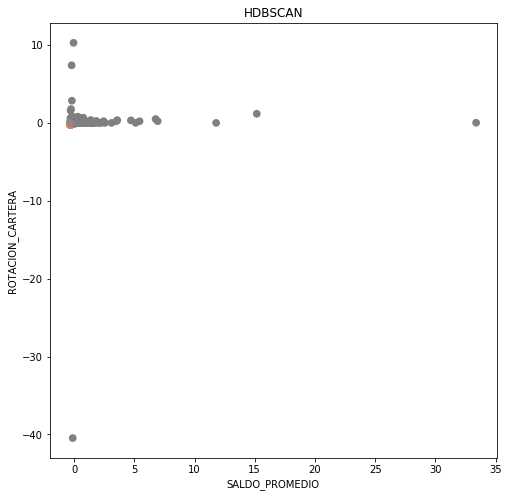

In [51]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.scatter( X.T[5] , X.T[6], s=60, linewidth=0, c=colors, alpha=1)
#plt.ylim(0.9,7)
#plt.xlim(0,1000000)
plt.xlabel('SALDO_PROMEDIO' ) #4
plt.ylabel('ROTACION_CARTERA') 
plt.title('HDBSCAN')

In [28]:
## COORDENADAS PARALELAS 
data = [
    go.Parcoords(
        line = dict(color = labels_  , colorscale='Viridis'  ) ,  
        dimensions = list([
            dict(#range = [0,8], 
                label = 'QUEJAS' ,      values = X[:, 0]),
            dict( range = [0,30],
                label = 'DAÑOS',        values = X[:, 1]),
            dict( #range = [0,8],
                label = 'CORTES',       values = X[:, 2]),
            dict( #range = [0,8],
                label = 'RECLAMOS',     values = X[:, 3]),
            dict( range = [0,500000],
                label = 'FACTURACION_PROMEDIO', values = X[:, 4]),
            dict( range = [0,500000],
                label = 'SALDO_PROMEDIO',   values = X[:, 5]),             
            dict( range = [0,3],
                label = 'ROTACION_CARTERA', values = X[:, 6]),  
            dict( #range = [0,8],
                label = 'COMUNA',        values = X[:, 7]), 
            dict( #range = [0,8],
                label = 'TI',        values = X[:, 8]), 
            dict( #range = [0,8],
                label = 'TI2',        values = X[:, 9]), 
            dict( #range = [0,8],
                label = 'TIPO_REPARTO',        values = X[:, 10]),  
            dict( #range = [-1, n_clusters_-1 ],#   K CLUSTERS
                label = 'CLUSTER', values = labels_) 
        ])
    )
]

layout = go.Layout(
    title='Segmentación de clientes HDBSCAN '+str(registros)+' Registros'+' '+str(n_clusters_)+' Clusters' ,
    plot_bgcolor = '#FFFFFF',
    paper_bgcolor = '#FFFFFF'
) 
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'hdbscan914'+str(registros))

In [11]:
np.unique(labels_)

array([-1,  0,  1,  2], dtype=int64)